<a href="https://colab.research.google.com/github/megan-the-astronomer/ASTR229/blob/main/cosmetic_improvements_and_cosmic_rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The PR image versus the science image

After doing the essential steps of subtracting the bias (and dark current) and dividing by the flat field, there are a few additional steps one can take to process an image. The big ones are removing cosmic rays and removing cosmetic artifacts.

Be careful when doing these steps! Correcting for a bad column in a mostly blank portion of sky is fine. What happens if your bad column runs through the middle of M82? This is one of the reasons we dither our images - so that the science target does not always land on the same place on the detector.

In [ ]:
# start by importing the necessities
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cosmetic defects

In [ ]:
im = fits.open('/content/drive/MyDrive/my_ASTR229_data/m82/obj0061.fits')[0].data

One of the prominent features of the raw data from the McDonald 30" is the bad column that runs through the center of the image. It is clear that this is a detector artifact because it is in every frame.

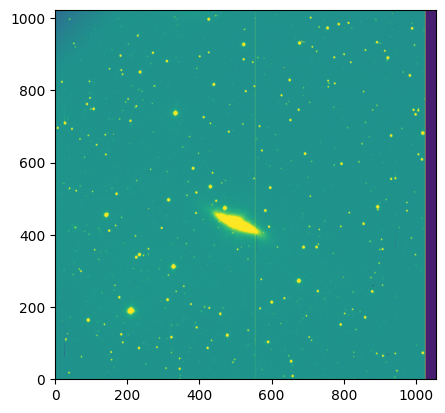

In [ ]:
plt.imshow(im, origin='lower', vmin=3000, vmax=5000)

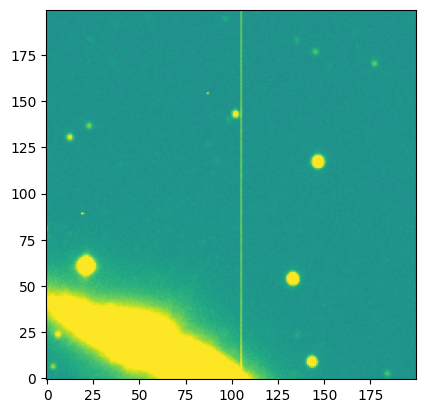

In [ ]:
plt.imshow(im[412:612,448:648], origin='lower', vmin=3000, vmax=5000)

Similarly, damaged pixels cannot transfer electrons during readout. Pixels below these 'traps' will be normal but data will be lost above them.  

Text(75, 105, '')

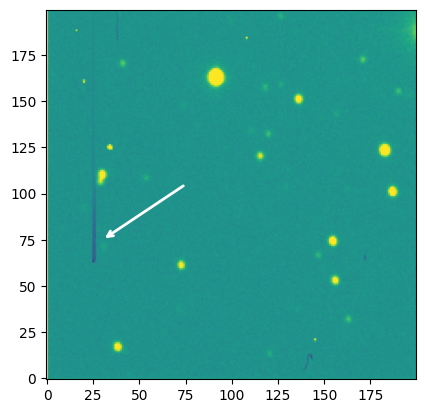

In [ ]:
plt.imshow(im[:200,:200], origin='lower', vmin=3000, vmax=5000)
# plot an arrow to point out the cosmic ray
plt.annotate("", xytext=(75, 105), xy=(30, 75),
            arrowprops=dict(arrowstyle="->", color='white', lw=2))

Dithering can help suppress this feature but often it is still visible in the combined image. There are two ways we can deal with this: (1) we can set the pixels in the bad column to ```NaN``` so they do not contribute to the image median or (2) we can interpolate to determine the most likely value of those pixels based on the information in pixels on either side of the bad column.

Question: which approach is better for the image you will use to do science?

Interpolation is a method to estimate data based on known data.

Conside the following simple 1D example.

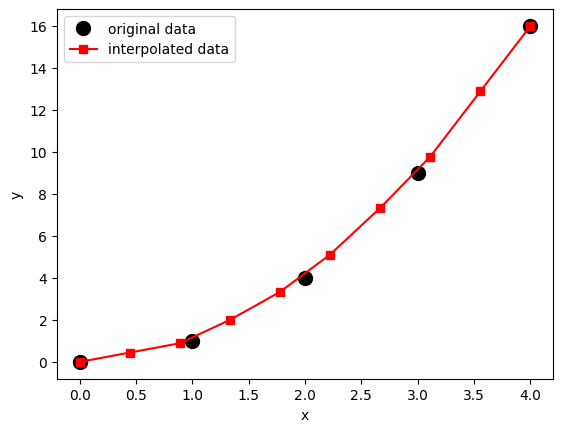

In [ ]:
# Known data
x = np.array([0, 1, 2, 3, 4])  # x-coordinates
y = np.array([0, 1, 4, 9, 16])  # y-coordinates (y = x^2)

# Create new x-coordinates for interpolation
x_new = np.linspace(0, 4, 10)  # 10 points between 0 and 4

# Perform linear interpolation
y_new = np.interp(x_new, x, y)

# Plot the results
plt.plot(x, y, 'o', label='original data', color='black', markersize=10)  # Original points
plt.plot(x_new, y_new, 's-', label='interpolated data', color='red')  # Interpolated line
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

We can do the same thing using good portions of the image on either side of the bad column. Try it for the V band images and see if it improves your combined image.

# Cosmic rays

Cosmic rays are high energy particles. When these hit the CCD, they leave behind a sharp signature - either a single pixel that is too small to be a star or a streak that is only ~1 pixel wide.

Let's a take a look at a cosmic ray in one of the M82 images from McDonald.

Text(55, 55, '')

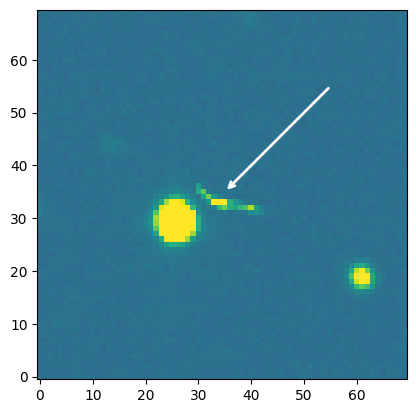

In [ ]:
# plot the image zooming in on the cosmic ray
plt.imshow(im[900:970,650:720], origin='lower', vmin=3000, vmax=5750)
# plot an arrow to point out the cosmic ray
plt.annotate("", xytext=(55, 55), xy=(35, 35),
            arrowprops=dict(arrowstyle="->", color='white', lw=2))

One way to confirm that something is a cosmic ray and not a real object is to check one of the other dithers. Do you see the object in the frame? Is it in the same place relative to the stars?

Text(155, 155, '')

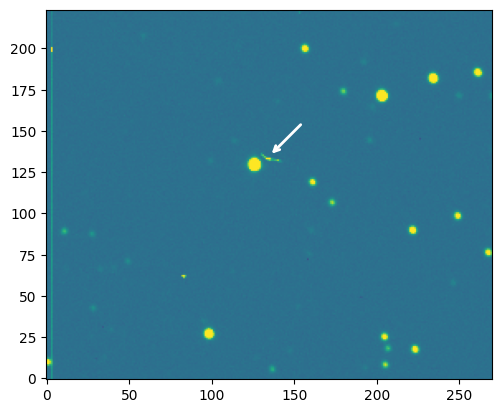

In [ ]:
# plot the image zooming in on the cosmic ray
plt.imshow(im[800:1070,550:820], origin='lower', vmin=3000, vmax=5750)
# plot an arrow to point out the cosmic ray
plt.annotate("", xytext=(155, 155), xy=(135, 135),
            arrowprops=dict(arrowstyle="->", color='white', lw=2))

If we look at the previous image, there is no cosmic ray next to the bright star.

Text(155, 105, '')

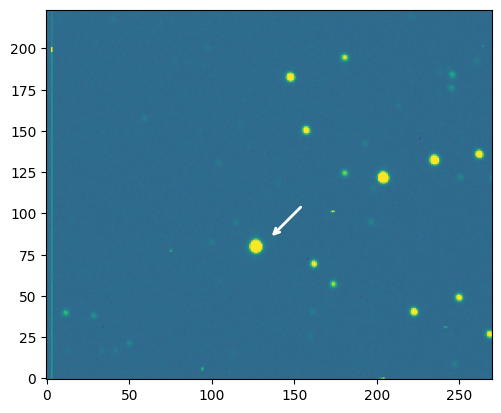

In [ ]:
im2 = fits.open('/content/drive/MyDrive/my_ASTR229_data/m82/obj0060.fits')[0].data

# plot the image zooming in on the cosmic ray
plt.imshow(im2[800:1070,550:820], origin='lower', vmin=3000, vmax=5750)
# plot an arrow to point out the cosmic ray
plt.annotate("", xytext=(155, 105), xy=(135, 85),
            arrowprops=dict(arrowstyle="->", color='white', lw=2))

If you do see the object in other frames but it is always at the same exact pixel location, then you are looking at a hot pixel. A hot pixel is stuck at a high value and is usually removed by the flat field.

Cosmic rays are one of the many reasons that we dither between exposures. Ideally, cosmic rays will be removed when combining multiple images because they are transient and will only show up in one image at any given location.

In some cases, cosmic rays need to be removed using other techniques such as sigma clipping. This method identifies significant outliers (values very different from the majority of the data) and excludes them. We could, for example, sigma clip the data before median combining our stacked image.

Buyer beware! Sigma clipping can also clip out real signal! Look at the pixel values of the cosmic ray in the image ```obj0061.fits```. Compare those to the counts in the neighboring star. The problem immediately becomes obvious.

Several algorithms have been developed to deal with this situation. The most widely used comes from [van Dokkum (2001)](https://iopscience.iop.org/article/10.1086/323894/pdf) and uses Laplacian edge detection. Essentially, cosmic rays have much sharper edges than stars which allows the two to be distinguished.

Ideally, our dithered data will remove the cosmic rays from our combined image but it's good to know these tools exist for when you might need them down the line.
